In [1]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context
# from google.colab import drive
# drive.mount("/content/gdrive")
pre_path =  ""#'/content/gdrive/My Drive/AN2DL_HW2/'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 80% !important; }</style>"))

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import logging
import random

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import cv2
from statsmodels.tsa.stattools import acf

# Setting seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Suppressing unnecessary warnings and logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(tf.__version__)

# Additional imports for the model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D, Activation,Input,Add


2023-12-16 17:24:48.542430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 17:24:48.542492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 17:24:48.578809: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 17:24:48.635709: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 17:24:52.933222: W tensorflow/compiler/tf2

2.15.0


In [3]:
X_train = np.load(pre_path + 'windowed_training_data/train_X.npy',allow_pickle='TRUE').item()
y_train = np.load(pre_path +'windowed_training_data/train_y.npy',allow_pickle='TRUE').item()

X_validation = np.load(pre_path +'windowed_training_data/validation_X.npy',allow_pickle='TRUE').item()
y_validation = np.load(pre_path +'windowed_training_data/validation_y.npy',allow_pickle='TRUE').item()

#X_test = np.load(pre_path +'windowed_training_data/test_X.npy',allow_pickle='TRUE').item()
#y_test = np.load(pre_path +'windowed_training_data/test_y.npy',allow_pickle='TRUE').item()

In [4]:
window = 206
output_shape = 18
training_categories = ['A', 'B', 'C', 'D', 'E', 'F']
X_train = np.concatenate([X_train[i] for i in training_categories]).reshape(-1,window,1)
y_train = np.concatenate([y_train[i] for i in training_categories])

X_validation = np.concatenate([X_validation[i] for i in training_categories]).reshape(-1,window,1)
y_validation = np.concatenate([y_validation[i] for i in training_categories])

#X_test = np.concatenate([X_test[i] for i in training_categories]).reshape(-1,window,1)
#y_test = np.concatenate([y_test[i] for i in training_categories])

In [5]:
nan_indices_X = np.isnan(X_train).any(axis=(1, 2))

# Find indices of rows with NaN values in y_train
nan_indices_y = np.isnan(y_train).any(axis=1)

# Combine the indices to get the common rows with NaN values
nan_indices = np.logical_or(nan_indices_X, nan_indices_y)

# Drop rows with NaN values from both X_train and y_train
X_train = X_train[~nan_indices]
y_train = y_train[~nan_indices]


# resnet + conv + Dense

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=3, stride=1):
    y = layers.Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    y = layers.Conv1D(filters, kernel_size=kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # If the number of filters is different or the stride is not 1, add a convolutional layer to the shortcut
    if stride != 1 or x.shape[-1] != filters:
        x = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)

    out = layers.add([x, y])
    out = layers.ReLU()(out)
    return out

def build_resnet(input_shape, num_classes=1):
    input_layer = layers.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv1D(32, kernel_size=3, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)


    x = residual_block(x, filters=32, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=64, stride=1)
    x = MaxPooling1D(pool_size=2)(x)


    x = residual_block(x, filters=64, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=128, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=128, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=256, stride=1)
    x = MaxPooling1D(pool_size=2)(x)

    x = residual_block(x, filters=256, stride=1)
    x = layers.GlobalAveragePooling1D()(x)

    output_layer = Dense(18)(x)


    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Define the input shape (adjust according to your data)
input_shape = (window, 1)

# Build the model
model = build_resnet(input_shape)

# Compile the model (customize the optimizer, loss, and metrics based on your task)
model.compile(optimizer=tf.optimizers.legacy.Adam(), loss='mean_squared_error')

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 206, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 206, 32)              128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 206, 32)              128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 206, 32)              0         ['batch_normalization[0][0

# Full convolutional model

In [7]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# def residual_block(x, filters, kernel_size=3, stride=1):
#     y = layers.Conv1D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
#     y = layers.BatchNormalization()(y)
#     y = layers.ReLU()(y)

#     y = layers.Conv1D(filters, kernel_size=kernel_size, padding='same')(y)
#     y = layers.BatchNormalization()(y)

#     # If the number of filters is different or the stride is not 1, add a convolutional layer to the shortcut
#     if stride != 1 or x.shape[-1] != filters:
#         x = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(x)
#         x = layers.BatchNormalization()(x)

#     out = layers.add([x, y])
#     out = layers.ReLU()(out)
#     return out

# def build_resnet(input_shape, num_classes=1):
#     input_layer = layers.Input(shape=input_shape)

#     # Initial convolutional layer
#     x = layers.Conv1D(32, kernel_size=3, strides=1, padding='same')(input_layer)
#     x = layers.BatchNormalization()(x)
#     x = layers.ReLU()(x)

#     # Residual blocks
#     x = residual_block(x, filters=64, stride=1)
#     x = MaxPooling1D(pool_size=2,padding = 'same')(x)


#     x = residual_block(x, filters=64, stride=1)
#     x = MaxPooling1D(pool_size=2,padding = 'same')(x)

#     x = residual_block(x, filters=128, stride=1)
#     x = MaxPooling1D(pool_size=2,padding = 'same')(x)

#     x = residual_block(x, filters=128, stride=1)
#     x = MaxPooling1D(pool_size=2,padding = 'same')(x)


#     x = residual_block(x, filters=64, stride=1)
#     x = MaxPooling1D(pool_size=2,padding = 'same')(x)

#     x = residual_block(x, filters=64, stride=1)
#     x = MaxPooling1D(pool_size=2,padding = 'same')(x)

#     x = residual_block(x, filters=32, stride=1)
#     x = MaxPooling1D(pool_size=2,padding = 'same')(x)

#     x = layers.Conv1D(18, kernel_size=3, strides=1, padding='same')(x)

#     # Global average pooling
#     output_layer = layers.GlobalAveragePooling1D()(x)


#     model = models.Model(inputs=input_layer, outputs=output_layer)
#     return model

# # Define the input shape (adjust according to your data)
# input_shape = (window, 1)

# # Build the model
# model = build_resnet(input_shape)

# # Compile the model (customize the optimizer, loss, and metrics based on your task)
# model.compile(optimizer=tf.optimizers.legacy.Adam(), loss='mean_squared_error')

# # Print the model summary
# model.summary()


# Training

In [8]:
model = load_model(pre_path + 'models/model_normalized_v2_all_categories_28_epoch.h5')
batch_size = 2**11
epochs = 4
with tf.device('gpu'):
    history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(X_validation, y_validation),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.9, min_lr=1e-6)
        ]
    ).history

2023-12-16 17:25:31.633204: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1360241072 exceeds 10% of free system memory.


Epoch 1/4
807/807 [==============================] - ETA: 0s - loss: 0.0091

2023-12-16 17:47:49.850137: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 466369168 exceeds 10% of free system memory.


807/807 [==============================] - 1430s 2s/step - loss: 0.0091 - val_loss: 0.0145 - lr: 5.3144e-04
Epoch 2/4
807/807 [==============================] - 1426s 2s/step - loss: 0.0090 - val_loss: 0.0157 - lr: 5.3144e-04
Epoch 3/4
807/807 [==============================] - 1427s 2s/step - loss: 0.0090 - val_loss: 0.0136 - lr: 5.3144e-04
Epoch 4/4
807/807 [==============================] - 1427s 2s/step - loss: 0.0089 - val_loss: 0.0148 - lr: 5.3144e-04


In [9]:
#test_loss = model.evaluate(X_test, y_test,batch_size = batch_size)

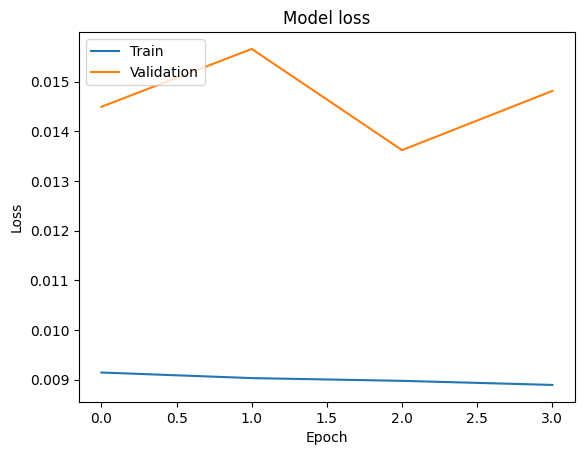

In [10]:
plt.figure()
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [11]:
model.save(pre_path + 'models/model_normalized_v2_all_categories_32_epoch.h5')

In [12]:
# model = load_model(pre_path + 'models/model_normalized_v2_all_categories_28_epoch.h5')
# batch_size = 2**11
# epochs = 4
# with tf.device('gpu'):
#     history = model.fit(
#         x = X_train,
#         y = y_train,
#         batch_size = batch_size,
#         epochs = epochs,
#         validation_data=(X_validation, y_validation),
#         callbacks = [
#             tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True),
#             tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, factor=0.9, min_lr=1e-6)
#         ]
#     ).history

# model.save(pre_path + 'models/model_normalized_v2_all_categories_32_epoch.h5')